Taking a crack at this: [Rossman store sales](https://www.kaggle.com/c/rossmann-store-sales/data)

# What are we up to here? 

We were given some data from a retailer, with all of their stores, and info about their clients and sales for each day. 

With this dataset, we want to create an estimator that can forecast sales on the next day. 

In [12]:
import pandas as pd 

# visualization stuff: 
import seaborn as sns
from matplotlib import pyplot as plt 
% matplotlib inline 

# A few optional things to get rid of useless warnings, and to make plots pretty
import warnings 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('seaborn')

In [13]:
# Let's get our dataset: 
train = pd.read_csv('../data/sales_data.csv', 
                    low_memory=False)  # this is used to ensure that it checks the types properly 
train.head(3)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
0,2013-01-01,1115,2,0,0,0,0,a,1,1,0,0,1
1,2013-01-01,378,2,0,0,0,0,a,1,1,0,0,1
2,2013-01-01,375,2,0,0,0,0,a,1,1,0,0,1


What types of object do we have? 

In [14]:
train.dtypes

Date                         object
Store                         int64
DayOfWeek                     int64
Sales                         int64
Customers                     int64
Open                          int64
Promo                         int64
StateHoliday                 object
SchoolHoliday                 int64
Next day is SchoolHoliday     int64
Next day is StateHoliday     object
Next day is a Promo           int64
Next day is Open              int64
dtype: object

We know this is a timeseries problem, so let's look at this `Date` index: 

In [15]:
train.Date.head()

0    2013-01-01
1    2013-01-01
2    2013-01-01
3    2013-01-01
4    2013-01-01
Name: Date, dtype: object

It's an object (bunch of strings). Pandas has lots of useful functionality to deal with timeseries, so let's turn these days into timeseries objects. We will use the [to_datetime](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) command.  

It can infer the format, but in general it is always a good idea to be explicit about the format. In this case we can see that our dates are Year-month-day (`format=%Y-%m-%d`)

In [16]:
train['Date'] = pd.to_datetime(train['Date'], 
                               format='%Y-%m-%d')  

Now we can make it our index, and then sort the dataframe on the date: 

In [17]:
train.set_index('Date', inplace=True)  # make the date the index
train.sort_index(inplace=True)         # sort the dataset on the index 

In [18]:
train.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
Date,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,1,0,0,1
2013-01-01,378,2,0,0,0,0,a,1,1,0,0,1
2013-01-01,375,2,0,0,0,0,a,1,1,0,0,1


Note that our index is not a datetime index: 

In [20]:
train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2015-05-29', '2015-05-29', '2015-05-29', '2015-05-29',
               '2015-05-29', '2015-05-29', '2015-05-29', '2015-05-29',
               '2015-05-29', '2015-05-29'],
              dtype='datetime64[ns]', name='Date', length=473922, freq=None)

# Stores

In [26]:
train.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
Date,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,1,0,0,1
2013-01-01,378,2,0,0,0,0,a,1,1,0,0,1
2013-01-01,375,2,0,0,0,0,a,1,1,0,0,1


We have a couple of things going on here. We have time, but we also have stores. We will try to, based on the previous day Sales of that Store, predict the sales of the next day. 

This is far from trivial, as we will explore. 

But, for now, let's observe a single store through time. Let's take that first store, #1115

In [29]:
train.loc[train.Store == 1115].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
Date,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,1,0,0,1
2013-01-02,1115,3,3697,305,1,0,0,1,1,0,0,1
2013-01-03,1115,4,4297,300,1,0,0,1,1,0,0,1
2013-01-04,1115,5,4540,326,1,0,0,1,1,0,0,1
2013-01-05,1115,6,4771,339,1,0,0,1,1,0,0,0


How  do it's sales behave through time? 

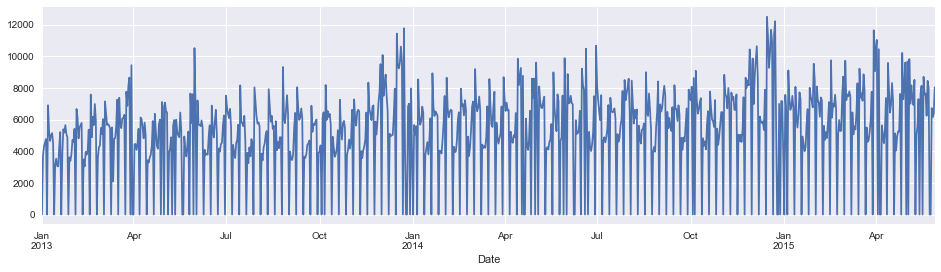

In [33]:
train.loc[train.Store == 1115, 'Sales'].plot(figsize=(16, 4))

Uau... that's kind of useless. 

The problem here is that we have a very strong effect of the day of the week, holidays, etc, so the signal is completely lost. 

One way to deal with this would be to use the [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) capability. Let's resample this to the week, and see what happens: 

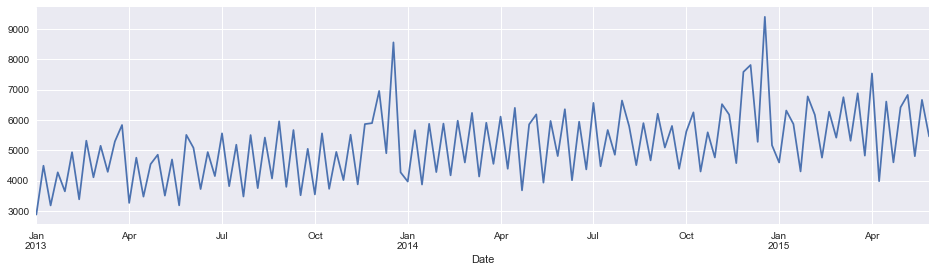

In [38]:
weekly_resampled_mean = train.loc[train.Store == 1115, 'Sales'].resample('w').mean()
weekly_resampled_mean.plot(figsize=(16, 4))

How does the day of the week affect this? 

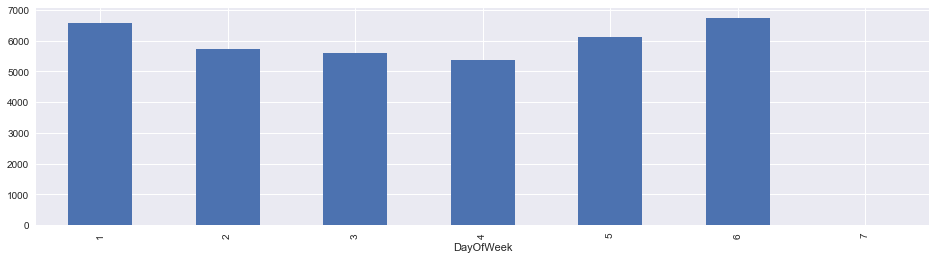

In [55]:
train.loc[train.Store == 1115].groupby('DayOfWeek')['Sales'].mean().plot(kind='bar', figsize=(16, 4))

So there are no sales on day 7 (Sunday?) and day 1 and 6 are the best ones. 

Maybe it would be interesting to get the mean per month? 

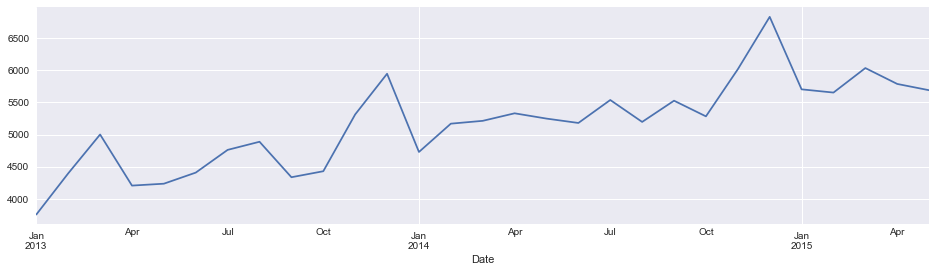

In [43]:
weekly_resampled_mean = train.loc[train.Store == 1115, 'Sales'].resample('m').mean()  
weekly_resampled_mean.plot(figsize=(16, 4))

Relatively clear trend, and it seems to be quite dependent on the month. 

#### How many stores do we have? 

We want to predict stores, and we've noticed we have stores that are open, and others that are closed. 

In [57]:
train.Store.nunique()

558

#### Do stores that have open == 0 ever sell anything?

In [58]:
train.groupby('Open')['Sales'].mean()

Open
0       0.000000
1    6947.130384
Name: Sales, dtype: float64

No, and that makes sense. Let's get a subset of open stores to observe then. 

In [59]:
train_open = train[train['Open']==1]   

How many clients visit these stores, on open days? 

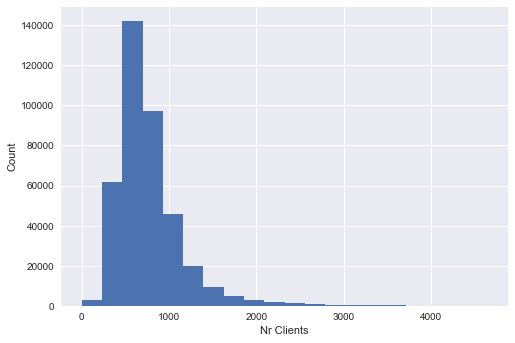

In [60]:
train_open.Customers.hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Nr Clients')

Actually, this isn't very useful. We're seeing the same store on lots of days, and lots of stores, which is completely not intuitive.  

What we want to know is: per store, what is the median number of clients, and then get a distribution of that.

We could do it this way... 

CPU times: user 1.09 s, sys: 9.89 ms, total: 1.1 s
Wall time: 1.13 s


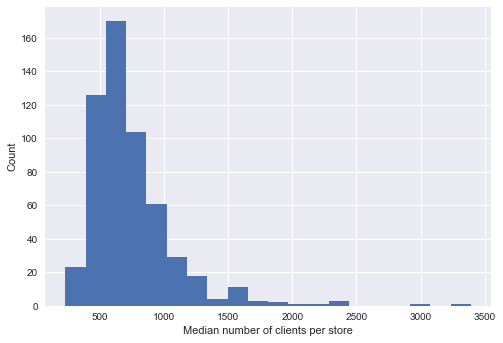

In [75]:
%%time
median_clients = {}  # <-- don't actually do this, it's just to exemplify
for store in train_open.Store.unique():
    median_clients[store] = train_open.loc[train_open.Store == store]['Customers'].median()
    
pd.Series(median_clients).hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median number of clients per store')

Or, in a more pandas way, we can do this with a [groupby](https://pandas.pydata.org/pandas-docs/stable/groupby.html). 

_(Also, notice the speedup we get!)_

CPU times: user 100 ms, sys: 6.45 ms, total: 107 ms
Wall time: 106 ms


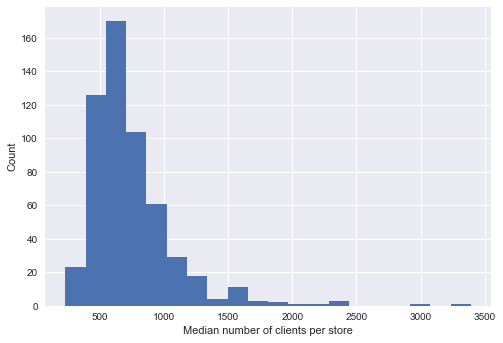

In [77]:
%%time
train_open.groupby('Store')['Customers'].median().hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median number of clients per store')

Same question for sales, what is the distribution of median sales, per store?

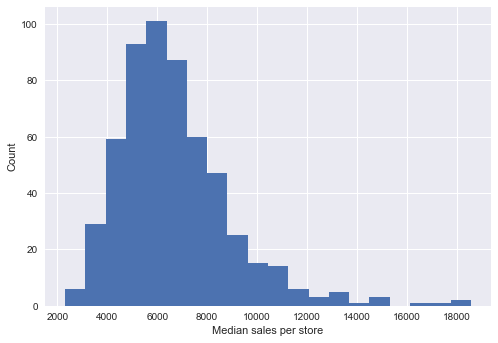

In [78]:
train_open.groupby('Store')['Sales'].median().hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median sales per store')

Obvious question: how does the number of clients correlate with sales?

In [79]:
train_open.Sales.corr(train_open.Customers)

0.80724546863151547

Can we visualize this?

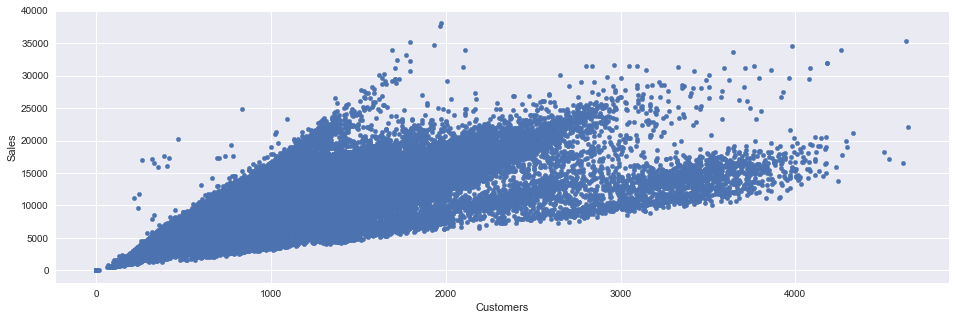

In [131]:
train_open.plot(kind='scatter',
                x='Customers',                
                y='Sales', 
               figsize=(16, 5))   # warning: this cell takes a while to run 

Interesting, if somewhat unclear. There seem to be multiple groups, but there are so many points that it is hard to tell. 

Let's [break the number of customers into bins](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html), to be able to calculate some medians

In [113]:
train_open['Customers_binned'] = pd.cut(train_open.Customers, bins=20)

What does this look like? 

In [114]:
train_open[['Customers', 'Customers_binned']].head()

,Customers,Customers_binned
Date,,
2013-01-01,527,"(464.5, 696.75]"
2013-01-01,532,"(464.5, 696.75]"
2013-01-01,729,"(696.75, 929.0]"
2013-01-01,1444,"(1393.5, 1625.75]"
2013-01-01,1039,"(929.0, 1161.25]"


It turned it into a discrete space. Now we can actually group by this `Customers_binned`, and see the median sales: 

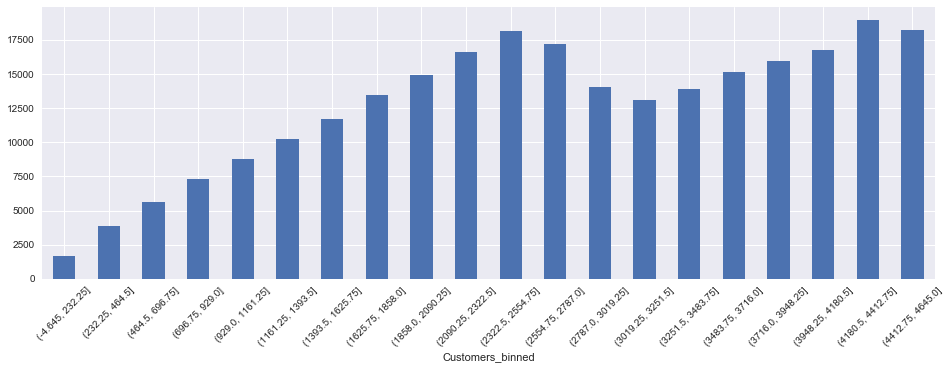

In [150]:
train_open.groupby('Customers_binned')['Sales'].median().plot(kind='bar', rot=45, figsize=(16, 5))

Very interesting, clearly this is linear to a point, and then changes. 

Theories: 
- Maybe they have other stores that have different pricing policies? 
- Maybe they open on different days of the week? 

Let's overlay the previous plot, with one showong how many stores are actually in each bin: 

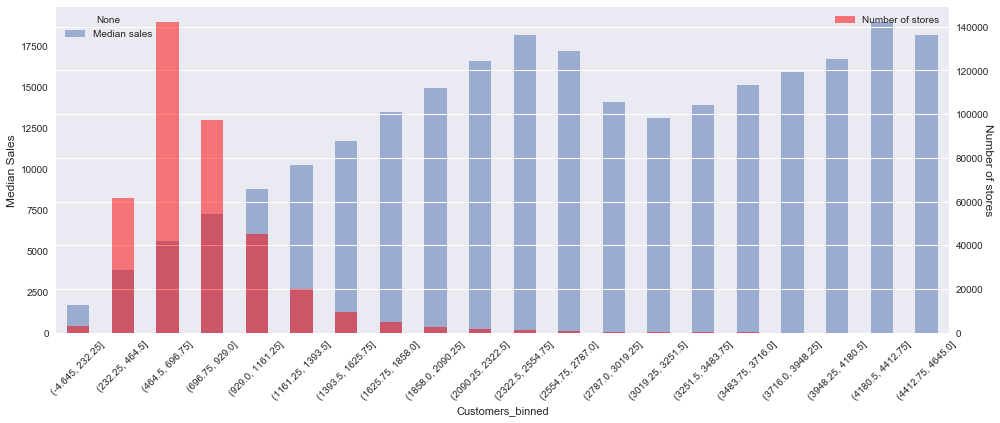

In [193]:
train_open.groupby('Customers_binned')['Sales'].median().plot(kind='bar', 
                                                              rot=45, 
                                                              alpha=.5, 
                                                              figsize=(16, 6),
                                                              label='Median sales')
plt.legend()
plt.ylabel('Median Sales', fontsize=12);

train_open.groupby('Customers_binned')['Sales'].count().plot(kind='bar', 
                                                             rot=45, 
                                                             alpha=.5,
                                                             color='r', 
                                                             label='Number of stores', 
                                                             secondary_y=True)
plt.legend()
plt.ylabel('Number of stores', fontsize=12, rotation=-90)

plt.show()

Interesting, so in reality almost all stores are in the linear relationship space, and the ones that aren't are in a long tail. 

We'd never have noticed this by looking at only one chart! 

#### How does DayOfWeek affect sales? 

Here, we will use a [seaborn boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

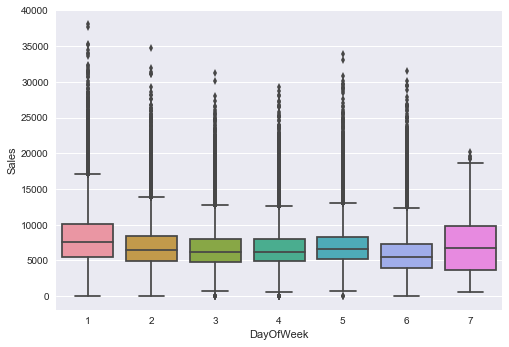

In [194]:
sns.boxplot(x=train_open['DayOfWeek'], 
            y=train_open['Sales'])

We have a bias here: we are looking into the open stores only, and it looks as though some stores might be open on Sundays. What would happen if we were looking at the full dataset? 

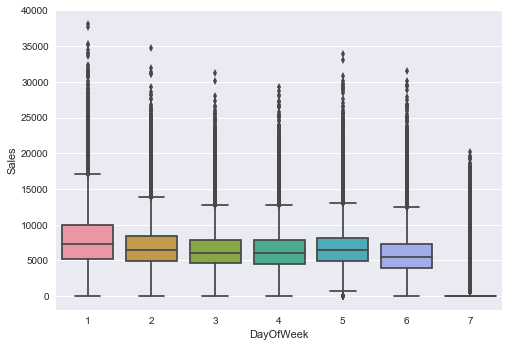

In [195]:
sns.boxplot(x=train['DayOfWeek'], 
            y=train['Sales'])  # using train instead of train_open

Interesting, it would seem that the stores that are open on Sundays have different behaviours. 

#### There seemed to be a promotions column. Do promotions work?

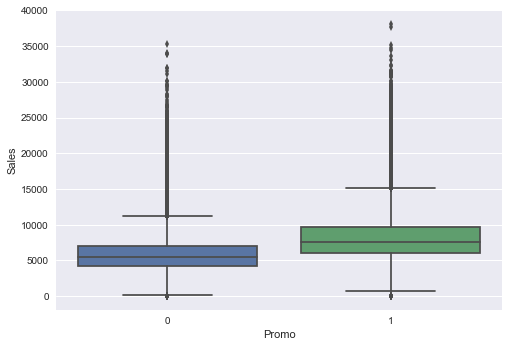

In [22]:
sns.boxplot(x=train_open['Promo'],
            y=train_open['Sales'])

Maybe... but we should be skeptical. Maybe promotions are done on days of the week, which might sell more anyway? Let's see how the boxplot of day of the week looks like, controlling for promotion:

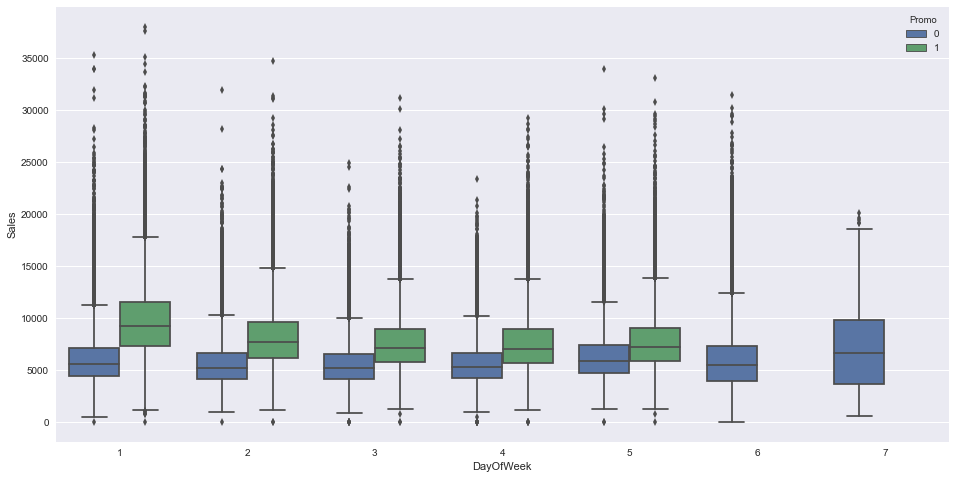

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x=train_open['DayOfWeek'], 
            y=train_open['Sales'], 
            hue=train_open['Promo'])   # the hue (color) will indicate if there was a promotion

Looks like promotions work, especially on Mondays. 

How about state Holidays? 

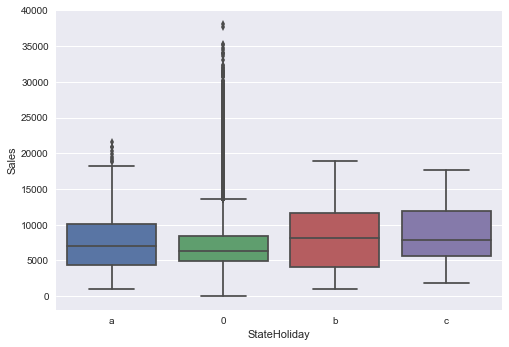

In [24]:
sns.boxplot(x=train_open['StateHoliday'], 
            y=train_open['Sales'])

Interestingly, it is categorical, and the box plots dealt with that very nicely. 

School holiday? 

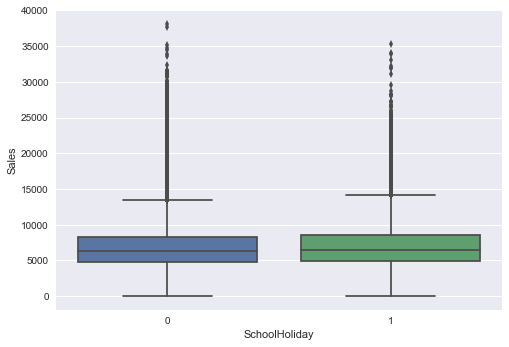

In [25]:
sns.boxplot(x=train_open['SchoolHoliday'], y=train_open['Sales'])
plt.show()

Excellent. Now we have an idea of what the data looks like, let's look at a few things from a timeseries point of view. 

# Timeseries analysis

Let's [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) the date to monthly 

In [26]:
monthly = train.resample('m')  # 'm' is monthly 

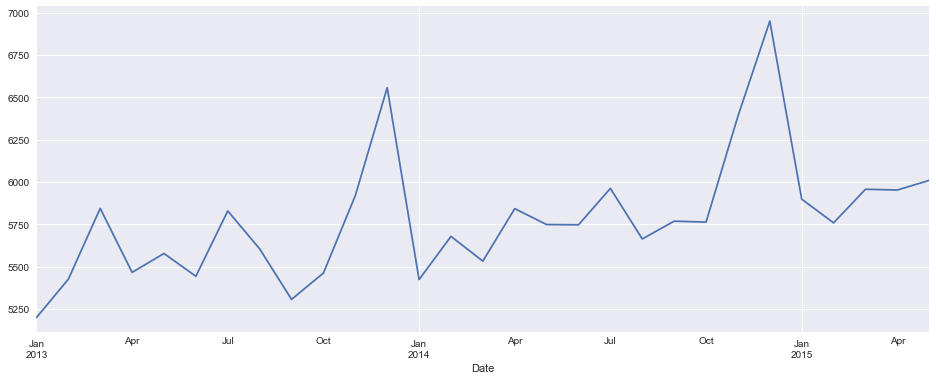

In [27]:
monthly.Sales.median().plot(figsize=(16, 6))

How does the month affect these results? We'll have to [create the month from the timeseries index](https://www.google.pt/search?q=pandas+month&oq=pandas+month+&aqs=chrome..69i57j69i60l5.1313j0j7&sourceid=chrome&ie=UTF-8)

In [196]:
train_open['Month'] = train_open.index.month

Great, now let's group per month and see what we get: 

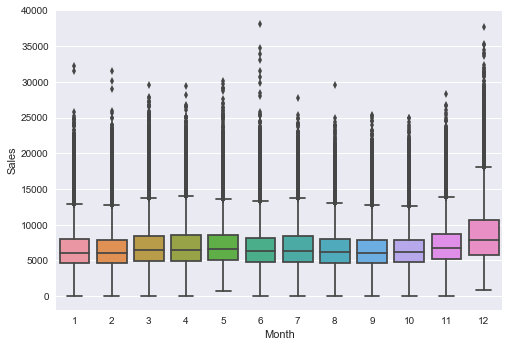

In [197]:
sns.boxplot(x=train_open['Month'], 
            y=train_open['Sales'])

Yep, December is clearly a different month. 